# Lesson 4 - Part 1

## Optimisation - or how to fit data

In this notebook, we will review briefly various concepts and Python tools that can be used to perform optimisation, model solving, and curve fitting.

***Dependencies***
- emcee
- corner
- numpy
- scipy
- matplotlib
- uncertainties

In [1]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.mlab import griddata
import matplotlib.tri as tri

import numpy as np
import scipy

# We fix the random seed to always get the same problem

np.random.seed(seed=42)

# Generating fake data: A simple curve fit with noise

We will fit a second order polynomial function, that can be calculate with the function defined below:

In [2]:
def my_polynomial(x,a,b,c):
    return a + x*b + c*x*x

We use this to generate a dataset, to which we add noise.

In [3]:
# true parameters
a = 10.0
b = 1.321
c = 0.02978

N = 100

x = np.sort(100*np.random.rand(N))
y = my_polynomial(x,a,b,c)

But real world observations are noisy... and we had a bias in observations. So the errors we know underestimate the true errors.

We will try to model this case there.


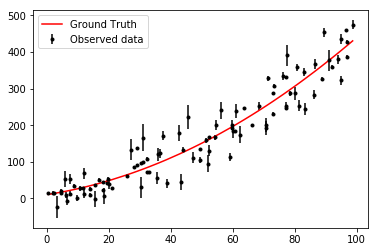

In [4]:
known_ese = np.random.randn(N)*15

f = 2 # our systematic bias coefficient
bias = np.sqrt(y)*f*np.random.randn(N) # the bias is a linear function of a normal distribution centred on x

true_ese = known_ese + bias

y_noisy = y + known_ese + true_ese # this is what we observe

plt.errorbar(x,y_noisy,yerr=known_ese,fmt='.',color="k",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.legend()

# Fitting the data

Suppose we had just been given these data points (as a set of points, $\{(x_1, d_1),(x_2,d_2)\ldots(x_N,d_N)\}$, and we didn't know anything about where they came from. From the plot, we might guess that they are well-approximated by a second-order polynomial (perhaps it could be a third-order polynomial, but the principle of "Occam's Razor" says we should try the simplest things first!).

Mathematically, we have just introduced a *model* for the process that generated this data - we are saying that we think

$$d_i = g(x_i,\mathbf{m}) = m_0+ m_1 x_i + m_2 x_i^2$$

The three parameters $m_0$, $m_1$ and $m_2$ are unknown *model parameters* that we would like to find. For convenience, we use $\mathbf{m}$ to denote the three parameters collectively (technically, this is the *model vector*).

We now need to find the values of these three coefficients in order that the model can explain the data as well as possible. In order to do this, we first need to define a measure of how well the two agree! By far the most common choice is to define a *misfit function*

$$\phi(\mathbf{d},\mathbf{m}) = \sum_{i=1}^N \left(d_i - g(x_i,\mathbf{m})\right)^2$$

The better the agreement is, the smaller $\phi$ will be. To find the best-fitting model, we simply(!) need to find the $\mathbf{m}$ that minimises $\phi(\mathbf{d},\mathbf{m})$. There are many ways to do this (and in fact, there is an analytical solution). However, for our purposes we can simply use the curve_fit function of scipy.

In [5]:
# we need to import curve_fit for fitting our curve
# we also import uncertainties for error propagation
from scipy.optimize import curve_fit 
import uncertainties

# then we fit and record the best parameters popt 
# and the covariance matrix pcov
popt, pcov = curve_fit(my_polynomial,x,y_noisy) 

# parameter errors are estimated from the square root of the diagonal of the covariance matrix
perr = np.sqrt(np.diag(pcov)) 

print("Obtained parameters:")
print(popt)
print("Errors:")
print(perr)


Obtained parameters:
[7.61445964 1.47450372 0.02808291]
Errors:
[1.11560639e+01 5.51137043e-01 5.48500647e-03]


We have found a set of values for $m_1$, $m_2$ and $m_3$. How well do they perform?

Fit RMSE is: 39.846089625969654


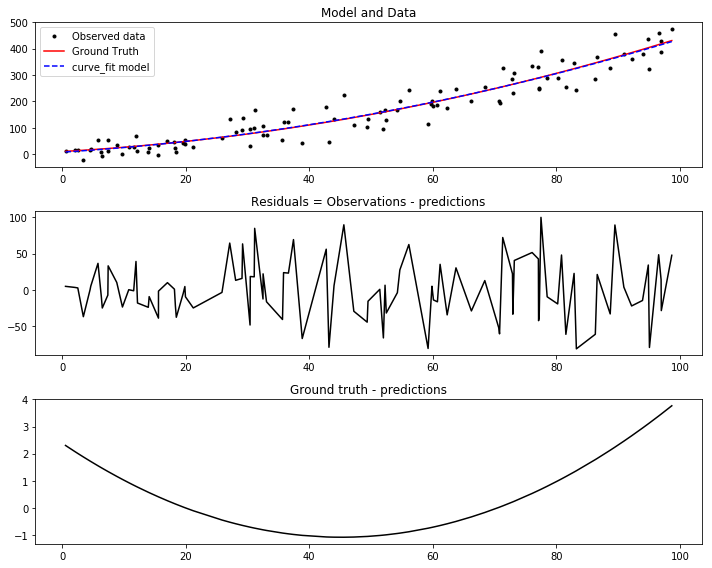

In [6]:
# we calculate the best estimate
y_pred_curvefit = my_polynomial(x,*popt) # parameter unwrapping (*popt) works only in Python 3

print("Fit RMSE is: "+str(np.sqrt(np.sum((y_pred_curvefit-y_noisy)**2)/N)))

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.plot(x,y_noisy,"k.",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.plot(x,y_pred_curvefit,"b--",label="curve_fit model")
plt.title("Model and Data")
plt.legend()

plt.subplot(3,1,2)
plt.plot(x,(y_noisy-y_pred_curvefit),"k-")
plt.title("Residuals = Observations - predictions")

plt.subplot(3,1,3)
plt.plot(x,(y-y_pred_curvefit),"k-")
plt.title("Ground truth - predictions")

plt.tight_layout()

Text(0.5,0,'observations - predictions')

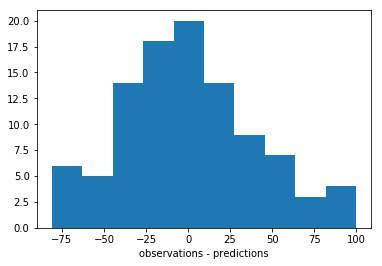

In [7]:
# Histogram of the residuals
plt.hist((y_noisy-y_pred_curvefit),bins=10)
plt.xlabel("observations - predictions")

# Hum, weird fit shape... 

Wait, we did not take into account the errors... 

Indeed, we should weight the square differences between *d* and *g* with the errors $\sigma$ on *d*.

Eq. 3 becomes in this case:

$$\phi(\mathbf{d},\mathbf{m}) = \sum_{i=1}^N \frac{1}{\sigma_i^2}\left(d_i - g(x_i,\mathbf{m})\right)^2$$

Fortunately, curve_fit can accept this in the function call.

Obtained parameters:
[5.90661575 1.61335965 0.02987336]
Errors:
[1.11560639e+01 5.51137043e-01 5.48500647e-03]
Fit RMSE is: 3.3335753357770783


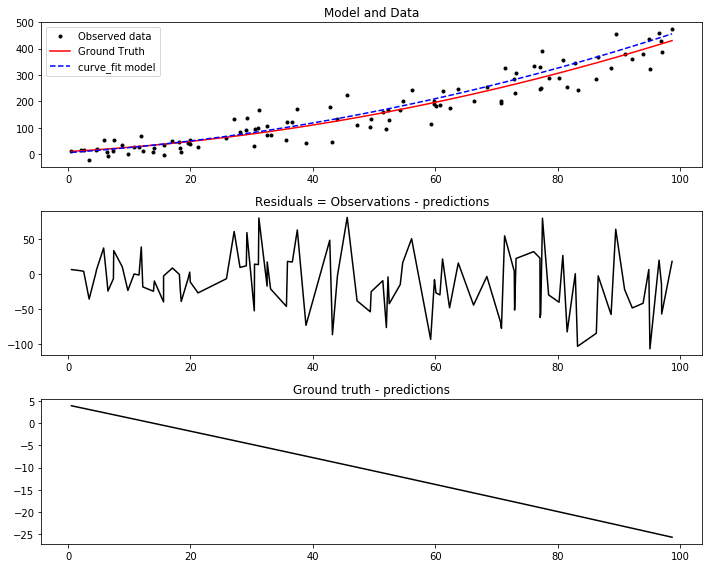

In [8]:
# then we fit and record the best parameters popt 
# and the covariance matrix pcov
popt, pcov = curve_fit(my_polynomial,x,y_noisy,sigma=known_ese) 

print("Obtained parameters:")
print(popt)
print("Errors:")
print(perr)

# parameter errors are estimated from the square root of the diagonal of the covariance matrix
perr = np.sqrt(np.diag(pcov)) 

# we calculate the best estimate
y_pred_curvefit = my_polynomial(x,*popt) # parameter unwrapping (*popt) works only in Python 3
print("Fit RMSE is: "+str(np.sqrt(np.sum(((y_pred_curvefit-y_noisy)/(f*np.sqrt(x)))**2)/N)))

plt.figure(figsize=(10,8))

plt.subplot(3,1,1)
plt.plot(x,y_noisy,"k.",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.plot(x,y_pred_curvefit,"b--",label="curve_fit model")
plt.title("Model and Data")
plt.legend()

plt.subplot(3,1,2)
plt.plot(x,(y_noisy-y_pred_curvefit),"k-")
plt.title("Residuals = Observations - predictions")

plt.subplot(3,1,3)
plt.plot(x,(y-y_pred_curvefit),"k-")
plt.title("Ground truth - predictions")

plt.tight_layout()

We still find the curvature, but the amplitude of residuals is smaller.

Could we plot the objective function for visualizing it? Let's evaluate the misfit on a grid...

In [9]:
a_ = np.linspace(-5,25,100)
b_ = np.linspace(-2,5.0,100)
c_ = 0.02978

record_misfit = np.zeros((len(a_),len(b_)))

def residual(x,y,a,b,c,sig):
    return np.sum(((y-my_polynomial(x,a,b,c))/sig)**2)

for i in range(len(a_)):
    for j in range(len(b_)):
        record_misfit[i,j] = residual(x,y_noisy,a_[i],b_[j],c_,f*np.sqrt(x))

...and now we can plot it!

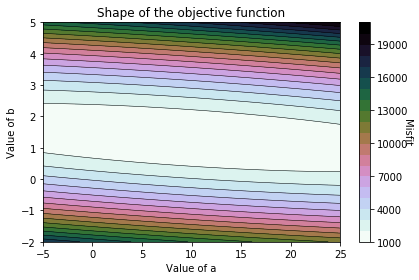

In [10]:
plt.figure()
CS = plt.contour(a_, b_, record_misfit.T, 20, linewidths=0.5, colors='k')
CS = plt.contourf(a_, b_, record_misfit.T, 20,
                  vmax=abs(record_misfit).max(), vmin=abs(record_misfit).min()
                  ,cmap=plt.cm.cubehelix_r)
cbar = plt.colorbar()
cbar.set_label('Misfit', rotation=270)

plt.xlabel("Value of a")
plt.ylabel("Value of b")

plt.title("Shape of the objective function")

plt.tight_layout()

# Can we do better? Or in other terms: more about optimisation and inverse problems

The curve_fit() function is nice, but it may not be appropriate for all problems. Moreover, error estimations are performed from the parameter covariance matrix pcov, which is not always the full story. Now, we are going to give a more general definition of the *optimisation* problem, which will allow us to fit complex models.

## The inverse problem ##

Eq. 1 describes how we believe data is generated for any choice of model parameters. This is sometimes known as the **forward problem**.

In general, in geoscience, we understand the forward problem relatively well. Our main task is finding the unknown parameters. This is said to be an [**inverse problem**](https://en.wikipedia.org/wiki/Inverse_problem), and to solve it we perform an **inversion**.

We did that with a common statistical least square approach in the previous cells. Now, we are going to switch from a statistical perspective to a Bayesian perspective. This will improve our vision of modelling, particularly regarding the error determination.

Adopting a Bayesian perspective, there is not longer one single 'best' model, but different models with associated probabilities, a.k.a likelihood. This implies that the most likely model may actually not be the good one, this is just the most likely model...

Another important point of a Bayesian perspective is that we assume some initial knowledge of the model parameters. Contrary to what is done in the curve_fit() function, we can use this knowledge to improve our ability to determine the parameters of the models, or, more precisely, their probability density function.

Typically, we define the probability of model $\mathbf{m}$ as the exponent of the negative misfit,
$$\begin{align}P(\mathbf{d} | \mathbf{m})& = k\cdot \exp\left\{-\frac{1}{2}\phi(\mathbf{d},\mathbf{m})\right\}\\&=k\cdot\exp\left\{ -\sum\frac{ (d_i - g_i(\mathbf{m}))^2}{2\sigma_i^2}\right\}\end{align}$$
where $k$ is a normalisation constant. You might recognise this formula - it is simply a multi-dimensional Gaussian.

We can now employ Bayes' theorem:

$$ P(\mathbf{m}|\mathbf{d}) = \frac{P(\mathbf{d}|\mathbf{m}) P(\mathbf{m})}{P(\mathbf{d})}$$

Here, $P(\mathbf{m})$ is the **prior distribution**, describing what we thought *before we saw the data*. $P(\mathbf{m}|\mathbf{d})$ is the **posterior distribution**, and describes our state of knowledge *after seeing the data*.


Text(0.5,1,'Model likelyhood function')

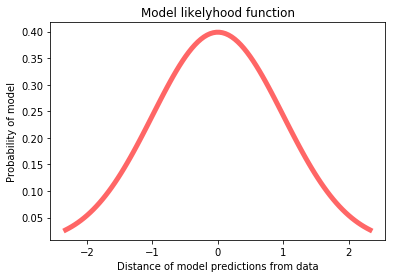

In [11]:
from scipy.stats import norm # this is a normal (gaussian) distribution of mean 0 and sigma 1

dm = np.linspace(norm.ppf(0.01),
                 norm.ppf(0.99), 100)
plt.plot(dm, norm.pdf(dm),
        'r-', lw=5, alpha=0.6, label='norm pdf')

plt.xlabel("Distance of model predictions from data")
plt.ylabel("Probability of model")
plt.title("Model likelyhood function")

According to Bayes' theorem, the probability of a model given a set of data includes *à prior* information *P*(**m**). In practice, we define a [**joint probability distribution**](https://en.wikipedia.org/wiki/Joint_probability_distribution) which will be equal to the sum of the likelyhood probability distribution of the model given the data times the *à prior* model probability distribution:

$$P(\mathbf{d} | \mathbf{m})=k\cdot\exp\left\{ -\sum\frac{ (d_i - g_i(\mathbf{m}))^2}{2\sigma_i^2}\right\}\cdot k\cdot\exp\left\{ -\sum\frac{ (m_n - m_{prior}))^2}{2\sigma_{m_{prior}}^2}\right\}$$

with *n* the number of model parameters. In practice, we will see two different forms of the last equation, one for a Gaussian probability and another one for a uniform probability. The graph below summarizes the idea for the *a* parameter.

The *a* parameter has a true value of 10.0. I could make a first-order estimate around 0 from the first figure, so assume 0 ± 20. We also assume a uniform distribution, because it is clear from the first plot that *a* cannot be lower than -20 or higher than 30, so we can say the model should present a uniform probability of 1 between -20 and 30, and a probability of 0 outside this range.

The following code allows generating a figure to compare the two different prior equations.

Text(0.5,1,'The prior probability functions for parameter a')

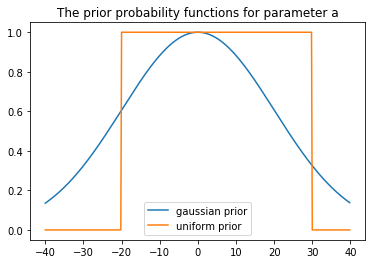

In [12]:
x_a = np.arange(-40,40,0.2)

# a dummy way to do a port function
uni = np.zeros(len(x_a))
uni[(x_a>-20)&(x_a<30)] = 1.0

# plotting things
plt.plot(x_a,np.exp(-1/2*(x_a - 0.0)**2/(20.**2)),label="gaussian prior") 
plt.plot(x_a,uni,label="uniform prior")
plt.legend()
plt.title("The prior probability functions for parameter a")

# Putting all those things in usable functions

Usually, the log of the probability distributions are used, as this avoids dealing with 0... We will do that below.

In addition, we are going to add a factor *f* in the likelyhood function to allow us to take into account the systematic errors adffecting our model (remember, the parameter 5 that we defined above). This will allow the model to be a bit more independent of the errors we provide, and in fine this should allow us to take into account any additional error that we were not aware of.

Our formula for the log likelyhood is now:

\begin{align}\log P(d|m) &= -\frac{1}{2}\left\{\sum_{i=1}^N \log 2\pi s_i^2+\sum_{i=1}^N \frac{(d_i-g_i(m))^2}{s_i^2}\right\}\end{align}

with 

\begin{align}s_i^2 = \sigma^2 + (f*\sqrt(x))^2 \end{align}

We assume there that we have some knowledge on our systematic bias. For instance, we know that our instrument has a systematic error that is increasing with the square root of x, but we don't know to which extent. We will try to find that by solving the inverse problem.

In [13]:
def logLikelihood(theta,x,y,yerr):
    
    a, b, c, lnf = theta
    model = my_polynomial(x,a,b,c)
    
    s_sq = yerr**2 + np.exp(2*lnf)*model # we know that the true model error is that observed plus a systematic bias
    
    return -0.5*(np.sum((y-model)**2/(s_sq) + np.log(2*np.pi*s_sq)))

In [14]:
def logPrior(theta):
    """log prior probability function for the parameters
    
    This implementation uses a uniform distribution
    
    Parameters
    ==========
    theta : list
        the parameters
        
    Returns
    =======
    logprob_prior : the estimated probability of the prior values
    
    """
    a ,b ,c ,lnf = theta
    
    if -20 < a < 30 \
    and -10 < b < 10 \
    and -10 < c < 10 \
    and -100 < lnf < 10: \
        return 0.0
    else:
        return - np.inf

In [15]:
def LogJoint(theta,x,y,yerr):
    
    lp = logPrior(theta)
    
    if not np.isfinite(lp):
        return -np.inf
    
    return lp+logLikelihood(theta,x,y,yerr)

# First step: estimate the maximum of the distribution

Now we can find the maximum likelyhood of this distribution using the minimize() function from scipy.optimize

We first define our prior model as list containing our estimates of initial *a*, *b*, *c* values plus an estimate of the scaling of the likelyhood distribution.

In [41]:
theta_prior = [9.,0.1,0.01,3]

Let's check if this model is probable with the logprior function

In [45]:
if logPrior(theta_prior) == 0:
    print("Model viable")

print("Joint Log Likelyhood is equal to")
print(LogJoint(theta_prior,x,y_noisy,known_ese))

Model viable
Joint Log Likelyhood is equal to
-612.4061214029797


# Second step

OK, seems we can go. Now, the good thing is that we can estimate the maximum likelyhood value with scipy.optimize.minimize

**1st note**: we had to play a bit with the initial value of lnf, which should be not too far from the reality, for the code to work. This is because we use a local solver in op.minimize. This problem could be avoided using a Differential Evolution of Simulated Annealing algorithm...

However, this also is why you should play with the definition of the prior and observe how your model parameters affect the value of the Log Likelyhood. (Cells above)

**2nd note**: the data are generated randomly, so you may find different parameters if you re-run the notebook. If the optimisation algorithm below fails, you should try to see how far your log likelyhood is from 0, and probably play with the lnf parameter (the 4th in the theta_prior array).

In [48]:
# Find the maximum likelihood value.
import scipy.optimize as op

# we need to take the negative of the Log Joint
nll = lambda *args: -logLikelihood(*args)

result = op.minimize(nll, theta_prior, args=(x, y_noisy,known_ese))
print(result)

      fun: 493.050014336703
 hess_inv: array([[ 5.11217332e-05, -3.16034213e-03,  4.68518922e-05,
         1.81702954e-03],
       [-3.16034213e-03,  4.31682825e-01, -6.30658694e-03,
        -2.47483699e-01],
       [ 4.68518922e-05, -6.30658694e-03,  9.35114954e-05,
         3.62742003e-03],
       [ 1.81702954e-03, -2.47483699e-01,  3.62742003e-03,
         1.63988103e-01]])
      jac: array([-7.62939453e-06,  0.00000000e+00,  9.68933105e-04,  5.34057617e-05])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 187
      nit: 18
     njev: 31
   status: 2
  success: False
        x: array([6.48668493, 1.53160565, 0.02743153, 1.01290375])


Obtained parameters:
[6.48668493 1.53160565 0.02743153]
Estimated bias
2.7535851478222964
Fit RMSE is: 39.85200582467724


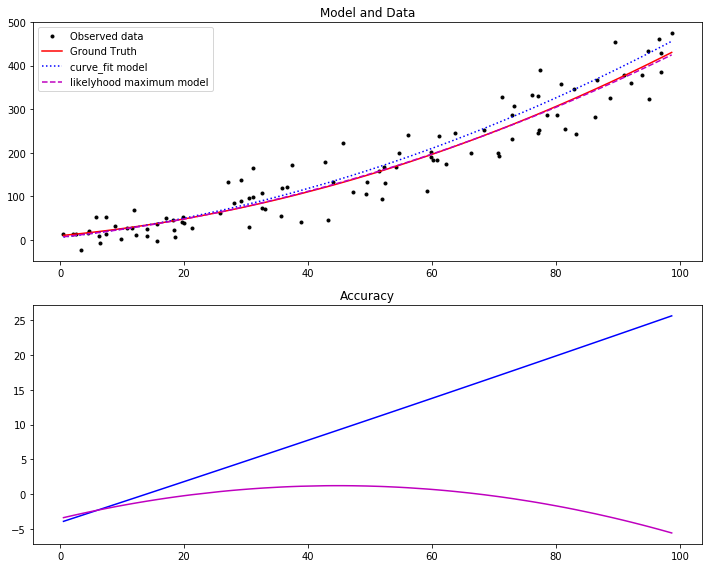

In [49]:
#Result is a dictionary, the best parameters are the x values.
popt_2 = result['x'][:-1]

print("Obtained parameters:")
print(result['x'][:-1])

print("Estimated bias")
print(np.exp(result['x'][-1]))

# we calculate the best estimate
y_pred_minimize = my_polynomial(x,*popt_2) # parameter unwrapping (*popt) works only in Python 3

print("Fit RMSE is: "+str(np.sqrt(np.sum((y_pred_minimize-y_noisy)**2)/N)))

plt.figure(figsize=(10,8))

plt.subplot(2,1,1)
plt.plot(x,y_noisy,"k.",label="Observed data")
plt.plot(x,y,"r-",label="Ground Truth")
plt.plot(x,y_pred_curvefit,"b:",label="curve_fit model")
plt.plot(x,y_pred_minimize,"m--",label="likelyhood maximum model")
plt.title("Model and Data")
plt.legend()

plt.subplot(2,1,2)
plt.plot(x,(y_pred_curvefit - y),"b-")
plt.plot(x,(y_pred_minimize - y),"m-")
plt.title("Accuracy")

plt.tight_layout()

# Result: Much Better!

Next time, we will see how to sample the posterior distribution to get a good idea of the errors affecting the parameters and have a true distribution of possible models!

Cheers!

Charles and Andrew.
